<a href="https://colab.research.google.com/github/YaoGroup/DIFFICE_jax/blob/main/tutorial/pinn_syndata.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tutorial: Viscosity inversion from synthetic data via PINNs

Fast running of the code requires **GPU hardware** to accelerate.

To choose GPU hardware, click the "Edit" in the toolbar above and select "Notebook settings".

In the pop-up windows, under the "Hardware accelerator", select "T4 GPU"

To ensure the code to run correctly in the colab, install the specific version of JAX below.

As it is a GPU version of JAX, it works only after selecting the T4 GPU as mentioned above

In [ ]:
# Install specific version (0.4.23) of JAX and Jaxlib
!pip install --upgrade jax==0.4.23 jaxlib==0.4.23+cuda12.cudnn89 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html

# Verify the installed version
import jax
print(jax.__version__)

Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 131.8/131.8 MB 8.0 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.26+cuda12.cudnn89
    Uninstalling jaxlib-0.4.26+cuda12.cudnn89:
      Successfully uninstalled jaxlib-0.4.26+cuda12.cudnn89
  Attempting uninstall: jax
    Found existing installation: jax 0.4.26
    Uninstalling jax-0.4.26:
      Successfully uninstalled jax-0.4.26
0.4.23


Copying the necessary python function from the [DIFFICE_jax](https://github.com/YaoGroup/DIFFICE_jax) GitHub repository

In [ ]:
!git clone https://github.com/YaoGroup/DIFFICE_jax

Cloning into 'DIFFICE_jax'...
remote: Enumerating objects: 486, done.
remote: Counting objects: 100% (206/206), done.
remote: Compressing objects: 100% (121/121), done.
remote: Total 486 (delta 194), reused 85 (delta 85), pack-reused 280
Receiving objects: 100% (486/486), 16.74 MiB | 15.67 MiB/s, done.
Resolving deltas: 100% (285/285), done.


Importing the required JAX library and function file from GitHub repository

In [ ]:
import jax.numpy as jnp
import numpy as np
from jax import random
from jax.tree_util import tree_map
from scipy.io import loadmat
import time

from DIFFICE_jax.data.prepare_data import data_sample_create
from DIFFICE_jax.model.initialization import init_MLP
from DIFFICE_jax.model.networks import solu_create
from DIFFICE_jax.model.prediction import predict
from DIFFICE_jax.equation.ssa_eqn_iso import vectgrad, gov_eqn, front_eqn
from DIFFICE_jax.optimizer.optimizer import adam_optimizer, lbfgs_optimizer
from DIFFICE_jax.tutorial.load_syndata import iceshelf_data


In [ ]:
def loss_create(predNN, scale, lw, lref0=1.):
    ''' a function factory to create the loss function based on given info
    :param lref0: loss value at the initial of the training
    :return: a loss function (callable)
    '''

    # define the mean squared error
    def _ms_error(diff):
        return jnp.mean(jnp.square(diff), axis=0)

    # loss function used for the PINN training
    def loss_fun(params, data):
        # update the loss_ref
        loss_ref = loss_fun.lref
        # create the function for gradient calculation involves input Z only
        net = lambda z: predNN(params, z)
        # load the data of normalization condition
        x_smp = data['smp'][0]
        u_smp = data['smp'][1]

        # load the position and weight of collocation points
        x_col = data['col'][0]
        x_bd = data['bd'][0]
        nn_bd = data['bd'][1]

        # calculate the gradient of phi at origin
        u_pred = net(x_smp)[:, 0:3]

        # calculate the residue of equation
        f_pred, term = gov_eqn(net, x_col, scale)
        f_bd, term_bd = front_eqn(net, x_bd, nn_bd, scale)

        # calculate the mean squared root error of normalization cond.
        data_err = _ms_error(u_pred - u_smp)
        # calculate the mean squared root error of equation
        eqn_err = _ms_error(f_pred)
        bd_err = _ms_error(f_bd)

        # set the weight for each condition and equation
        data_weight = jnp.array([1., 1., 0.6])
        eqn_weight = jnp.array([1., 1.])
        bd_weight = jnp.array([1., 1.])

        # calculate the overall data loss and equation loss
        loss_data = jnp.sum(data_err * data_weight)
        loss_eqn = jnp.sum(eqn_err * eqn_weight)
        loss_bd = jnp.sum(bd_err * bd_weight)

        # calculate the total loss
        loss = (loss_data + lw[0] * loss_eqn + lw[1] * loss_bd) / loss_ref
        # group the loss of all conditions and equations
        loss_info = jnp.hstack([jnp.array([loss, loss_data, loss_eqn, loss_bd]),
                                data_err, eqn_err, bd_err])
        return loss, loss_info

    loss_fun.lref = lref0
    return loss_fun


# Setting hyperparameters

In [ ]:
# select the random seed
seed = np.random.choice(3000, 1)[0]
key = random.PRNGKey(seed)
np.random.seed(seed)

# create the subkeys
keys = random.split(key, 4)

# select the size of neural network
n_hl = 5
n_unit = 30
lw = [0.05, 0.1]

# number of sampling points
n_smp = 4000
n_col = 4000
n_cbd = 600
n_pt = jnp.array([n_smp, n_col, n_cbd], dtype='int32')
n_pt2 = n_pt * 2   # double the points for L-BFGS

# create the dataset filename
DataFile = 'SynData_exp1.mat'

# obtain the data for training
data_all = iceshelf_data(DataFile, step=1)
scale = data_all[4][0:2]

# Initializing the model and the loss function

In [ ]:
# initialize the weights and biases of the network
trained_params = init_MLP(keys[0], n_hl, n_unit)

# create the solution function
pred_u = solu_create()

# create the data function for Adam
dataf = data_sample_create(data_all, n_pt)
keys_adam = random.split(keys[1], 5)
data = dataf(keys_adam[0])
# create the data function for L-BFGS
dataf_l = data_sample_create(data_all, n_pt2)
key_lbfgs = keys[2]

# calculate the loss function
NN_loss = loss_create(pred_u, scale, lw)
# update the reference value of the loss
NN_loss.lref = NN_loss(trained_params, data)[0]


# Training using ADAM optimizer

In [ ]:
# set the learning rate for Adam
lr = 1e-3
# set the training iteration
epoch1 = 100

# training with Adam
trained_params, loss1 = adam_optimizer(keys_adam[1], NN_loss, trained_params, dataf, epoch1, lr=lr)


Step: 20 | Loss: 2.0265e-01 | Loss_d: 3.3012e-01 | Loss_e: 4.8155e-02 | Loss_b: 1.4061e-03
Step: 40 | Loss: 1.5191e-01 | Loss_d: 2.4815e-01 | Loss_e: 8.8986e-03 | Loss_b: 7.6690e-03
Step: 60 | Loss: 1.4286e-01 | Loss_d: 2.3421e-01 | Loss_e: 3.1072e-03 | Loss_b: 1.5477e-03
Step: 80 | Loss: 1.3993e-01 | Loss_d: 2.2941e-01 | Loss_e: 3.2204e-03 | Loss_b: 1.2916e-03
Step: 100 | Loss: 1.2835e-01 | Loss_d: 2.0990e-01 | Loss_e: 9.7846e-03 | Loss_b: 3.0084e-03


# Training using L-BFGS optimizer
(optional setup in order to reach higher accuracy of the model)

In [ ]:
# set the training iteration
epoch2 = 400
# re-sample the data and collocation points
data_l = dataf_l(key_lbfgs)

# training with L-bfgs
trained_params, loss2 = lbfgs_optimizer(NN_loss, trained_params, data_l, epoch2)

# Computing the output of trained networks

Compute the solution and equation residue at high-resolution grids

In [ ]:
# create the function for trained solution and equation residues
f_u = lambda x: pred_u(trained_params, x)
f_gu = lambda x: vectgrad(f_u, x)[0][:, 0:6]
f_eqn = lambda x: gov_eqn(f_u, x, scale)

# group all the function
func_all = (f_u, f_gu, f_eqn)

# calculate the solution and equation residue at given grids for visualization
results = predict(func_all, data_all)


# Plotting the results:

Compare the synthetic data for either velocity or thickness with the corresponding network approximation

Text(0.5, 1.0, 'Network approx. $u(x,y)$')

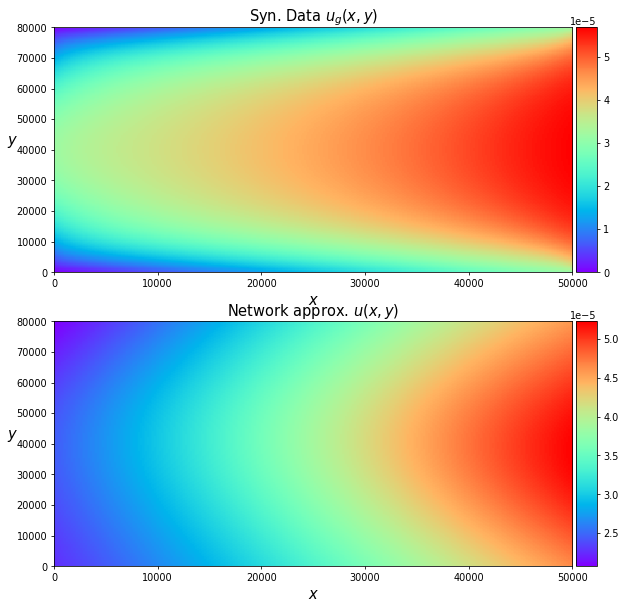

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

u_g = results['u_g']
u = results['u']

fig = plt.figure(figsize = [10, 10], dpi = 70)

ax = plt.subplot(2,1,1)
h = ax.imshow(u_g, interpolation='nearest', cmap='rainbow',
              extent=[0., 50000., 0,  80000.],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$x$', fontsize = 15)
ax.set_ylabel('$y\ $', fontsize = 15, rotation = 0)
ax.set_title('Syn. Data $u_g(x,y)$', fontsize = 15)


ax2 = plt.subplot(2,1,2)
h2 = ax2.imshow(u, interpolation='nearest', cmap='rainbow',
              extent=[0., 50000., 0,  80000.],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h2, cax=cax)

ax2.set_xlabel('$x$', fontsize = 15)
ax2.set_ylabel('$y\ $', fontsize = 15, rotation = 0)
ax2.set_title('Network approx. $u(x,y)$', fontsize = 15)


Compare the given viscosity profile with inferred viscosity via PINNs

Text(0.5, 1.0, 'PINN inversion $\\mu(x,y)$')

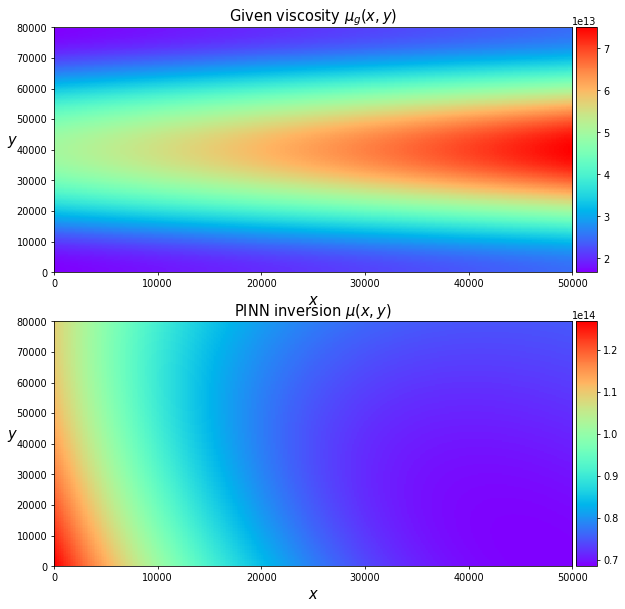

In [ ]:
# load the given viscosity (ground truth)
mu_g = data_all[5]
# load the PINN inference of viscosity
mu = results['mu']

fig = plt.figure(figsize = [10, 10], dpi = 70)

ax = plt.subplot(2,1,1)
h = ax.imshow(mu_g, interpolation='nearest', cmap='rainbow',
              extent=[0., 50000., 0,  80000.],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h, cax=cax)

ax.set_xlabel('$x$', fontsize = 15)
ax.set_ylabel('$y\ $', fontsize = 15, rotation = 0)
ax.set_title('Given viscosity $\mu_g(x,y)$', fontsize = 15)


ax2 = plt.subplot(2,1,2)
h2 = ax2.imshow(mu, interpolation='nearest', cmap='rainbow',
              extent=[0., 50000., 0,  80000.],
              origin='lower', aspect='auto')
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="4%", pad=0.05)
fig.colorbar(h2, cax=cax)

ax2.set_xlabel('$x$', fontsize = 15)
ax2.set_ylabel('$y\ $', fontsize = 15, rotation = 0)
ax2.set_title('PINN inversion $\mu(x,y)$', fontsize = 15)
